In [1]:
# MATH-UA 2791 Final Project (Fall 2020)
# Group Memebers: Jialiang Chen(jc8663), Yue Li(yl4881), Zoe Lu(xl2192)


import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader
import pandas_datareader.data as web
import datetime
npr.seed(2)

# Scheme 1: Log Normal and Hull-White

## Calculating $\sigma_x$, $\sigma_s$, and $\rho_{xs}$ from historical data

In [2]:

StockPrices = pd.DataFrame()
ticker_list = ['^STOXX50E', 'EURUSD=X', ]
start = datetime.datetime(2019,1,1)
end = datetime.datetime(2020,1,1)
for ticker in ticker_list:
    stock_data = web.DataReader(ticker, 'yahoo',start, end)
    StockPrices[ticker] = stock_data['Close']  
StockPrices.index.name = 'date' 
StockPrices.dropna(inplace = True)
StockPrices

,^STOXX50E,EURUSD=X
date,,
2019-01-03,2954.659912,1.131811
2019-01-04,3041.850098,1.139108
2019-01-07,3033.639893,1.141044
2019-01-08,3054.939941,1.147974
2019-01-09,3070.239990,1.145607
...,...,...
2019-12-19,3739.169922,1.111593
2019-12-20,3776.560059,1.112595
2019-12-23,3776.659912,1.107984


In [3]:
#simga_s
StockPrices['S_return'] = StockPrices['^STOXX50E'].pct_change()
StockPrices['S_log_return'] = np.log(StockPrices['S_return']+1)
StockPrices.dropna(inplace = True)
StockPrices.head()

,^STOXX50E,EURUSD=X,S_return,S_log_return
date,,,,
2019-01-04,3041.850098,1.139108,0.029509,0.029082
2019-01-07,3033.639893,1.141044,-0.002699,-0.002703
2019-01-08,3054.939941,1.147974,0.007021,0.006997
2019-01-09,3070.239990,1.145607,0.005008,0.004996
2019-01-10,3075.729980,1.155495,0.001788,0.001787


In [4]:
mean_s = StockPrices['S_log_return'].mean()
r_s = StockPrices['S_log_return'].values
diff_square = [(r_s[i]-mean_s)**2 for i in range(0,len(r_s))]
std_s_2 = np.sum(diff_square)
std_s = np.sqrt(std_s_2/(len(r_s)-1))
std_s /= np.sqrt(1/252)
std_s

0.1424978728350279

In [5]:
#sigma_x
StockPrices['X_return'] = StockPrices['EURUSD=X'].pct_change()
StockPrices['X_log_return'] = np.log(StockPrices['X_return']+1)
StockPrices = StockPrices.mask(np.isinf(StockPrices))
StockPrices.dropna(inplace = True)
StockPrices.head()


,^STOXX50E,EURUSD=X,S_return,S_log_return,X_return,X_log_return
date,,,,,,
2019-01-07,3033.639893,1.141044,-0.002699,-0.002703,0.001700,0.001699
2019-01-08,3054.939941,1.147974,0.007021,0.006997,0.006073,0.006054
2019-01-09,3070.239990,1.145607,0.005008,0.004996,-0.002062,-0.002064
2019-01-10,3075.729980,1.155495,0.001788,0.001787,0.008631,0.008594
2019-01-11,3070.040039,1.151013,-0.001850,-0.001852,-0.003879,-0.003886


In [6]:
mean_x = StockPrices['X_log_return'].mean()
r_x = StockPrices['X_log_return'].values
diff_square_x = [(r_x[i]-mean_x)**2 for i in range(0,len(r_x))]
std_x_2 = np.sum(diff_square_x)
std_x = np.sqrt(std_x_2/(len(r_x)-1))
std_x /= np.sqrt(1/252)
std_x

0.05488716945790251

In [7]:
corr = StockPrices.corr()
corr

,^STOXX50E,EURUSD=X,S_return,S_log_return,X_return,X_log_return
^STOXX50E,1.000000,-0.729119,0.050578,0.051476,0.009777,0.010151
EURUSD=X,-0.729119,1.000000,0.022371,0.022881,0.124460,0.124211
S_return,0.050578,0.022371,1.000000,0.999950,-0.146418,-0.145585
S_log_return,0.051476,0.022881,0.999950,1.000000,-0.148111,-0.147264
X_return,0.009777,0.124460,-0.146418,-0.148111,1.000000,0.999995
X_log_return,0.010151,0.124211,-0.145585,-0.147264,0.999995,1.000000


## Model Parameters

In [8]:
S0 = StockPrices.iloc[0,0] #initial price of STOXX50E from historical data
a = 0.3 #mean-revertion factor(made up by us) 
rf = -0.25/100 #risk-free rate(1 year Euro rate on Jan 3, 2019, data from European Central Bank)
q = 0.0261 #dividend yield from yahoo finance
sigma_s = std_s #Calculated from historical price data
sigma_x = std_x #Calculated from historical price data
sigma_r = 0.8 #volatility of short rate(made up by us)
rho_sx = corr.loc['X_log_return']['S_log_return'] #correlation between two stochastic processes X and S 
rho_sr = 0.65 #Correlation between S and r, made up by us 
Delta = 0.25 #Delta is 3 months
T = 1 #1 year maturity
k_1 = 0.53 #strik price for the stock part made up by ourselves
k_2 = 0.07 #need to be changed
theta_rate = 25 # the decreasing rate of theta 

ytm1 = 2.5 #data from U.S treasury department; this will be used to calculate p(0,T)

#In order to calculate price for p(0, T-delta), we need to do an interpolation from other treasury bonds
#Daily US Treasury Yield Curve Rate on Jan 3, 2019
#https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yieldYear&year=2019
xp = [1.0/12, 2.0/12, 3.0/12, 0.5, 1, 2, 3, 5, 7, 10, 20, 30]
yp = [2.42,2.42,2.41,2.47,2.50,2.39,2.35,2.37,2.44,2.56,2.75,2.92]

ytm2 = np.interp(0.75, xp, yp) #yield to maturity for T-delta (9 months here)
print ("ytm2:", ytm2)
p1 = 1.0/(1+ytm1/100) #price of p(0,T)
p2 = 1.0/(1+ytm2/100)**0.75 #price of p(0,T-delta)

print ("p1,p2:",p1, p2) 

#In order to calculate f(0, T-delta), we need to calculate -dlogp(0,T)/dT, which can be appoached
#by interpolation and numerical methods
logy = np.log(yp)
y = np.interp(0.75, xp, logy)
y_d = np.interp(0.751, xp, logy)
dx = 0.001
f = -(y_d-y)/dx #f(0,T-delta) 

y_2 = np.interp(0.1, xp, logy)
y_2_d = np.interp(0.101, xp, logy)
r0 = -(y_2_d-y_2)/dx #r(0), also f(0,0)
print(r0)

ytm2: 2.4850000000000003
p1,p2: 0.9756097560975611 0.9817587280029728
-0.0


Two-factor simulation with time steps (determine $r^j(T-\Delta)$ and $S^j(T)$:
$$r_{k+1}-r_k=(\theta(t_k)-ar_k)\Delta t+\sigma_r\sqrt{\Delta t}\tilde{\varepsilon}$$
$$S_T=S_0\exp\left((r_f-q-\rho_{x,S}\sigma_x\sigma_S)T+\sigma_S\sqrt{T}\varepsilon\right)$$

In [9]:
#Use Cholesky decomposition to generate correlated epsilons
corr_mat = np.zeros((2,2))
corr_mat[0,:] = [1.0,rho_sr]
corr_mat[1,:] = [rho_sr,1.0]
cho_mat = np.linalg.cholesky(corr_mat)
cho_mat

array([[1.        , 0.        ],
       [0.65      , 0.75993421]])

In [10]:
# parameters for the simulation
Nsim = 100000
M = 252
dt = T/M
ran_num = npr.standard_normal(size = (2,M,Nsim))
print(ran_num.shape)
print(np.average(ran_num))


(2, 252, 100000)
9.211058951206733e-05


In [11]:
# epsilon[0] is for rate and [1] is for stock
epsilon = np.zeros_like(ran_num)
for i in range(0, Nsim):
    epsilon[:, :, i]=np.dot(cho_mat, ran_num[:, :, i])*dt
    


In [12]:
np.corrcoef(epsilon[0,:,2],epsilon[1,:,2])

array([[1.        , 0.67636954],
       [0.67636954, 1.        ]])

$\Pi_{T}=\max \left[0,\left(\frac{S(T)}{S(0)}-k\right) \cdot\left(\frac{L^{j}(T-\Delta, T-\Delta, T)}{L(0, T-\Delta, T)}-k^{\prime}\right)\right]$

0.000133116662475712
The drift is -0.027448199675057346, the vol is 0.1424978728350279.
Scheme 1: S_part average is  0.97298282185797


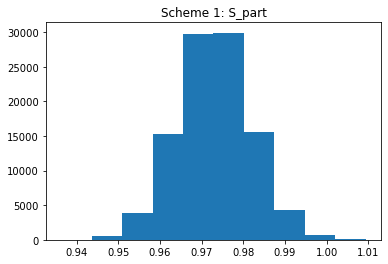

In [13]:
# Stock part of final payoff
epsilon_s = np.sum(epsilon[1], axis = 0)
print(np.average(epsilon_s))

#S(T)/S(0) for each trajectory
S_part = np.exp((rf-q-rho_sx*sigma_x*sigma_s)*T + sigma_s*np.sqrt(T)*epsilon_s)   
plt.hist(S_part)
plt.title ("Scheme 1: S_part")
print('The drift is {}, the vol is {}.'.format(rf-q-rho_sx*sigma_x*sigma_s, sigma_s))
S_part_avg = np.average(S_part)
print ("Scheme 1: S_part average is ", S_part_avg)

 Next we do the Libor part
 
$$ L(t ; S, T)=-\frac{p(t, T)-p(t, S)}{(T-S) p(t, T)}$$

Libor Ratio in the payoff: 

$$\frac{(1-p(T-\Delta,T)) \times (p(0,T))}{p(T-\Delta,T) \times (p(0,T-\Delta)-p(0,T)))}$$


In [14]:
#Libor part of final payoff
#function to compute L_ratio
def L_ratio(p):
    return ((1-p)*(p1))/(p*(p2-p1))
L_ratio(0.92)

13.796717934316938

$$B(T-\Delta, T)=\frac{1}{a}\left(1-e^{-a\Delta)}\right))$$

In [15]:
#function to compute B(T-Delta, T) and P(T-Delta, T)
def B(Delta):
    return (1/a)*(1-np.exp(-a*Delta))
B(Delta)

0.24085504557149048

$$
\begin{aligned}
p(T-\Delta, T) &=\frac{p(0, T)}{p(0, T-\Delta)} \\
& \times \exp \left(B(T-\Delta, T) f(0, T-\Delta)-\frac{\sigma^{2}}{4 a} B^{2}(T-\Delta, T)\left(1-e^{-2 a t}\right)-B(T-\Delta, T) r(T-\Delta)\right)
\end{aligned}
$$

In [16]:
#function to compute p(T-Delta, T)
def P(r):
    return (p1 / p2) * np.exp(B(Delta) * f - (sigma_r**2)/(4*a)*B(Delta)*B(Delta)*(1-np.exp(-2*a*(T-Delta)))-B(Delta)*r)
L_ratio(P(0.07))


6.503168807353982

Need to derive: $$
r^{j}(T-\Delta)
$$ where $$
r_{k+1}-r_{k}=\left(\theta\left(t_{k}\right)-a r_{k}\right) \Delta t+\sigma_{r} \sqrt{\Delta t} \tilde{\varepsilon}
$$
$$\theta(t) = e^{-at}$$

(252, 100000)
Cut is 189.0
(253, 100000)
0.9697472731066903
The simulation results of rate at T-Delta is r[189], it has shape (100000,)
The average r at T-delta is 0.03076553889621757


Text(0.5, 1.0, 'simulated rate curve with theta rate = 25')

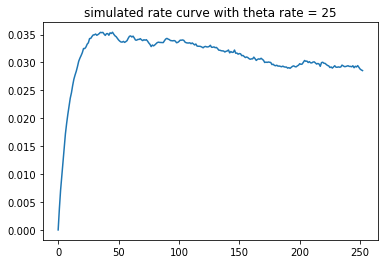

In [17]:
def theta(t, a):
    return np.exp(-a*t)

print(epsilon[0].shape)
cut = ((T-Delta)/T)*M
print("Cut is",cut)
r=np.zeros([M+1, Nsim])
print(r.shape)
r[0,:] = r0
for k in range(1, len(r)):
    r[k,:] = r[k-1,:]+(theta(dt*k, theta_rate)-a*r[k-1])*dt + sigma_r*np.sqrt(dt)*epsilon[0][k-1]


L_part = L_ratio(P(r[189]))         # The L_part in our payoff
print(np.average(P(r[189])))

print("The simulation results of rate at T-Delta is r[189], it has shape", r[int(cut)].shape)

plt.plot(r[:,2000])
print("The average r at T-delta is", np.average(r[189]))
plt.title("simulated rate curve with theta rate = " +str (theta_rate))

The average of L_part is 4.9497659236016975


Text(0.5, 1.0, 'Scheme 1: L_part with theta rate = 25')

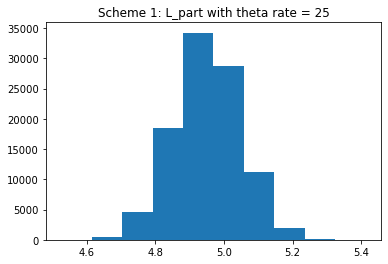

In [18]:
L_part_avg = np.average(L_part)
print("The average of L_part is", L_part_avg)
plt.hist(L_part)
plt.title ("Scheme 1: L_part with theta rate = " + str(theta_rate))

Compute the payoff of each of the trajectories:$$
\Pi_{T}^{j}(L, S)=\max \left[0,\left(\frac{S(T)}{S(0)}-k\right) \cdot\left(\frac{L^{j}(T-\Delta, T-\Delta, T)}{L(0, T-\Delta, T)}-k^{\prime}\right)\right]
$$

The average of the product of L_part and S_part is 0.13387619666809356
Number of postive payoffs is 100000
Average payoff is 0.13387619666809356


Text(0.5, 1.0, 'Scheme 1: payoff at T')

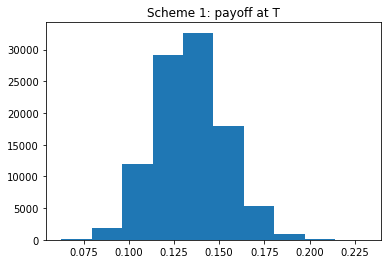

In [19]:
#pi = np.maximum(0, np.multiply((S_part - k) * (L_part - k_2)))
temp = np.multiply((S_part-k_1),(L_part-k_2))

print("The average of the product of L_part and S_part is",np.average(temp))
print("Number of postive payoffs is", sum(x > 0 for x in temp))
#The payoff of each of the trajectories
pi = np.maximum(0,temp)     
print("Average payoff is", np.average(pi))
plt.hist(pi)
plt.title ("Scheme 1: payoff at T")

Discount factors for each of the trajectories:$$
\exp \left(-\int_{0}^{T} r_{u} d u\right) \sim \exp \left(-\sum_{k=1}^{N} r\left(t_{k}\right) \Delta t\right)
$$

(253, 100000)
[0.96743558 0.96854527 0.96787748 ... 0.96915347 0.97060066 0.9730257 ]


Text(0.5, 1.0, 'Scheme 1: discount factors with theta rate = 25')

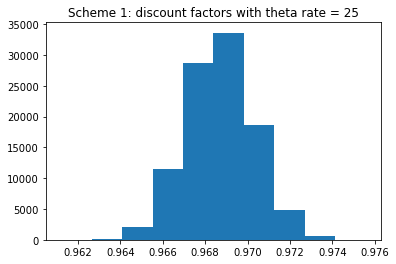

In [20]:
print(r.shape)
def dis_f(r):
    return np.exp(-np.sum(r*dt, axis = 0))
discount = dis_f(r)
print (discount)
discount.shape
plt.hist(discount)
plt.title("Scheme 1: discount factors with theta rate = " + str(theta_rate))



The Final payoff of this product:
    $$
\mathbb{E}^{Q}\left[\exp \left(-\int_{0}^{T} r_{u} d u\right) \times \Pi_{T}\right]
$$

The price of this product is 0.1297124610566754


Text(0.5, 1.0, 'discounted payoff of Scheme 1 with theta rate = 25')

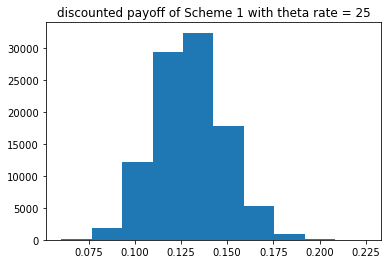

In [21]:
price = np.average(np.multiply(discount, pi))

plt.hist(np.multiply(discount,pi))
print("The price of this product is", price)
plt.title ("discounted payoff of Scheme 1 with theta rate = " + str(theta_rate) )

array([[-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [ 0.00351013,  0.00358222,  0.00316628, ...,  0.00411458,
         0.00355032,  0.0034135 ],
       [ 0.00670253,  0.00656691,  0.00622308, ...,  0.00700985,
         0.00675558,  0.00635517],
       ...,
       [ 0.02892874,  0.02814799,  0.02730142, ...,  0.02516954,
         0.02903477,  0.02074993],
       [ 0.02910084,  0.02800678,  0.0273782 , ...,  0.02514674,
         0.02901653,  0.02043304],
       [ 0.02887024,  0.02768346,  0.02742713, ...,  0.02498801,
         0.0289144 ,  0.02018424]])

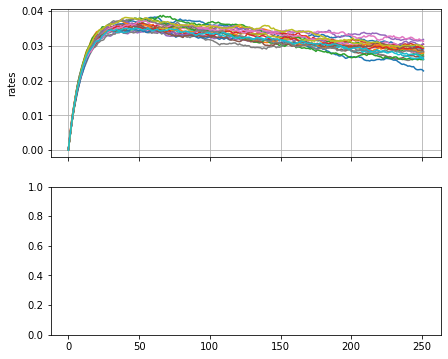

In [22]:
fig,(ax1,ax2)=plt.subplots(2,1,sharex=True,figsize=(7,6))
ax1.plot(r[:252,:20])
ax1.set_ylabel('rates')
ax1.grid(True)
r

# Scheme 2:lognormal & lognormal LIBOR
rho_sp$=\rho_{p,S}$, rho_sl$=\rho\langle{dW,dZ}\rangle$
Assume LIBOR is lognormal

In [23]:
S0

3033.639892578125

In [24]:
sigma_x     # USD/EURO-vol: sigma_x from historical adj close data
sigma_s     # Stock-vol: sigma_s from historical adj close data
sigma_p=0.05  # bond-vol made up by us (should change this later)!!
sigma_r      # short-rate-vol : sigma_r made up by us
sigma_l = 0.1 # LIBOR-vol made up by us (should change this later)!!


rho_sx # corr (stock, USE/EURO)

rho_sl=0.65 # corr (stock, LIBOR), made up by us (should change this later) !!
rho_sp=-rho_sl # corr (stock, bond), by our assumption

r_f_d = 2.5/100 # risk-free rate during 2019 in the US

T # 1yr maturity
DeltaT= T-Delta # T-delta = 9 months duration

k_1 # strike price for the stock (made up by us)
k_2 # k'

corr_mat2=np.zeros((2,2))
corr_mat2[0,:]=[1,rho_sl]
corr_mat2[1,:]=[rho_sl,1]

cho_mat2=np.linalg.cholesky(corr_mat2)
cho_mat2

M=252
I=100000
dt = T/M

In [25]:
corr_mat2
ran_num2 = np.random.standard_normal((2,I))
epsilons = np.dot(cho_mat2, ran_num2)
epsilons.shape


(2, 100000)

$$S_T=S_0\exp\left((r_f-q-\rho_{x,S}\sigma_x\sigma_S+\rho_{p,S}\sigma_S\sigma_p)T+\sigma_s\sqrt{T}\varepsilon\right)$$

Scheme 2: S_part average is  0.9784031885083873


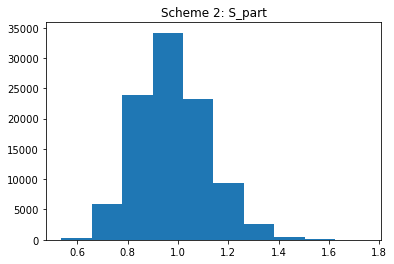

In [26]:
# Spart = ST/S0
Spart = np.exp((rf - q - rho_sx * sigma_x * sigma_s + rho_sp * sigma_s * sigma_p) * T +
               sigma_s * np.sqrt (T) * epsilons[0]) 
Spart_avg = np.average (Spart)
plt.hist(Spart)
plt.title("Scheme 2: S_part")
print("Scheme 2: S_part average is ", Spart_avg)


In [27]:
#Calculate L0, which is f(0,T)
y_2 = np.interp(1, xp, logy)
y_d_2 = np.interp(1.001, xp, logy)
dx_2 = 0.001
f_2 = -(y_d_2-y_2)/dx_2 #f(0,T) 
L0 = f_2
print(L0)

0.044997365930776745


$$L(0, T-\Delta, T)=L_{0} \exp \left(\sigma_{L} \sqrt{T-\Delta} \tilde{\varepsilon}\right)$$

0.045183786294563176

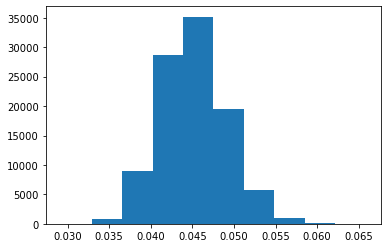

In [28]:
L = L0 * np.exp(sigma_l * np.sqrt(T - Delta) * epsilons[1])
plt.hist(L)
np.average(L)

$$
p(0, T-\Delta)=p(0, T)+L(0, T-\Delta, T) \cdot \Delta \cdot p(0, T)
$$

In [29]:
p_temp1 = p1 + L * Delta * p1
np.average(p_temp1)


0.986630191779162

In [30]:
p2

0.9817587280029728

From No arbitraage: $$
p(T-\Delta, T)=\frac{p(0, T)}{p(0, T-\Delta)}
$$

In [31]:
p_temp2 = np.zeros_like(p_temp1)
p_temp2 = p1/p2

Libor in the payoff: $$
\frac{(1-p(T-\Delta, T)) \times(p(0, T))}{p(T-\Delta, T) \times(p(0, T-\Delta)-p(0, T)))}
$$

In [32]:
#Libor part of final payoff
#function to compute L_ratio
#In this model, p(T-Delta,T) and p(0,T-Delta) are both input from our simulated L_ratio
def L_ratio_2(p, p2):
    return ((1-p)*(p1))/(p*(p2-p1))
Lpart = L_ratio_2(p_temp2, p_temp1)
Lpart_avg = np.average(Lpart)



The average of L_part is 0.5621620827358431


Text(0.5, 1.0, 'Scheme 2: L_part')

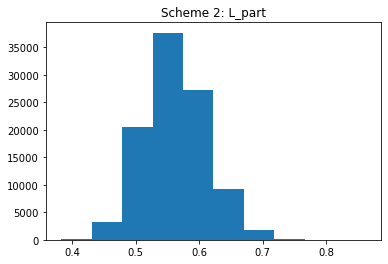

In [33]:
print("The average of L_part is",Lpart_avg)
plt.hist(Lpart)
plt.title("Scheme 2: L_part")

$$
\Pi_{T}=\max \left[0,\left(\frac{S(T)}{S(0)}-k\right) \cdot\left(\frac{L^{j}(T-\Delta, T-\Delta, T)}{L(0, T-\Delta, T)}-k^{\prime}\right)\right]
$$

In [34]:
type(Lpart - k_2)
type(np.multiply((Spart - k_1), (Lpart - k_2)))

numpy.ndarray

Average payoff is: 0.7511976446574363


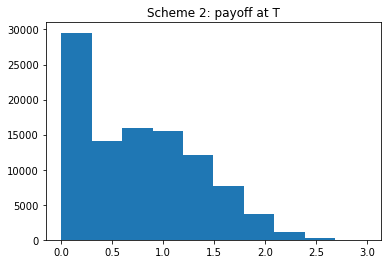

In [35]:
pi_2 = np.maximum(0, np.multiply((Spart - k_1), (Lpart - k_2)))
plt.hist(pi_2)
plt.title("Scheme 2: payoff at T")
print("Average payoff is:", np.average(pi_2))

Calculate the constant discount rate:$$
\exp \left(-\int_{0}^{T} r d u\right) \sim \exp \left(-\sum_{k=1}^{N} r \Delta t\right)
$$

In [36]:
temp_r = np.zeros(M)[:] = r_f_d * dt
dis_f_const = np.exp(-np.sum(temp_r))
print("The discount factor is constant in Scheme 2:",dis_f_const)


The discount factor is constant in Scheme 2: 0.9999007985715808


$$
\mathbb{E}^{Q}\left[\exp \left(-\int_{0}^{T} r d u\right) \times \Pi_{T}\right]
$$

The price of this product is  0.7511231247780612


Text(0.5, 1.0, 'discounted payoff of Scheme 2')

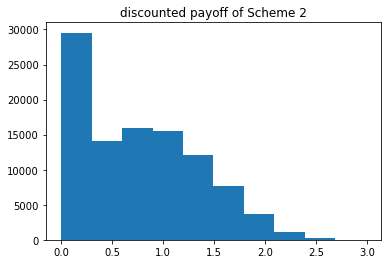

In [37]:

price_2 = np.average(pi_2[:] * dis_f_const)
print("The price of this product is ",price_2)
plt.hist(np.multiply(pi_2,dis_f_const))
plt.title("discounted payoff of Scheme 2")

## --------------------------------------------------------------------------------------------------------

# Final Print

In [38]:
print ("Method 1 HW pricing:" , price) # price resulted from Hull-White in method 1
print ("Method 2 lognormal LIBOR pricing:", price_2) # price from lognormal LIBOR assumption in method 2


Method 1 HW pricing: 0.1297124610566754
Method 2 lognormal LIBOR pricing: 0.7511231247780612
